# Homework 17 - Abalone Classification

**1.	What is inductive reasoning? Deductive reasoning? Give an example of each, different from the examples given in class.** 

**Using ONE of the following sources, complete the questions for only that source.** 
- Credit approval: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29
- Cardiac Arrhythmia: https://archive.ics.uci.edu/ml/datasets/Arrhythmia 
- Abalone age: https://archive.ics.uci.edu/ml/datasets/Abalone - this one is a bit harder since it’s not binary like the others, but if you really want to master these concepts, you should pick this one. Use RMSE as a performance metric if you do this as regression. You should target a value of under 3.  

*Note: at least one of your models should have the most relevant performance metric above .90 . All performance metrics should be above .75 . You will partially be graded on model performance.*


**2.	Preprocess your dataset. Indicate which steps worked and which didn’t. Include your thoughts on why certain steps worked and certain steps didn’t.** 

In [98]:
import numpy as np
import pandas as pd

# Import the file
abalone = pd.read_csv('abalone.csv')

# Original data length
print(len(abalone.index))

# View file
abalone.sample(5)

4177


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
738,M,0.535,0.410,0.135,0.8620,0.2855,0.1525,0.3200,14
1480,F,0.580,0.460,0.175,1.1650,0.6500,0.2205,0.3055,9
2196,I,0.370,0.280,0.090,0.2330,0.0905,0.0545,0.0700,11
3953,I,0.465,0.355,0.120,0.5805,0.2550,0.0915,0.1840,8
955,M,0.495,0.395,0.135,0.6335,0.3035,0.1295,0.1495,8


In [11]:
# Check data types
abalone.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

In [8]:
# Confirm how many null values there are
abalone.isnull().sum()

        # No missing data to handle

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [4]:
# View the unique sex categories
abalone['Sex'].unique()

array(['M', 'F', 'I'], dtype=object)

In [99]:
# Encode the sex variables into binary
sex_enc = pd.get_dummies(abalone['Sex'])
sex_enc.head()

,F,I,M
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


In [100]:
# Concatenate the data frames and confirm that the encoding seems correct
abalone_df = pd.concat([abalone, sex_enc], axis=1)
abalone_df.head() # everything looks good

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,F,I,M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [101]:
# Drop the original sex variable from data frame
abalone_df = abalone_df.drop('Sex', axis=1)

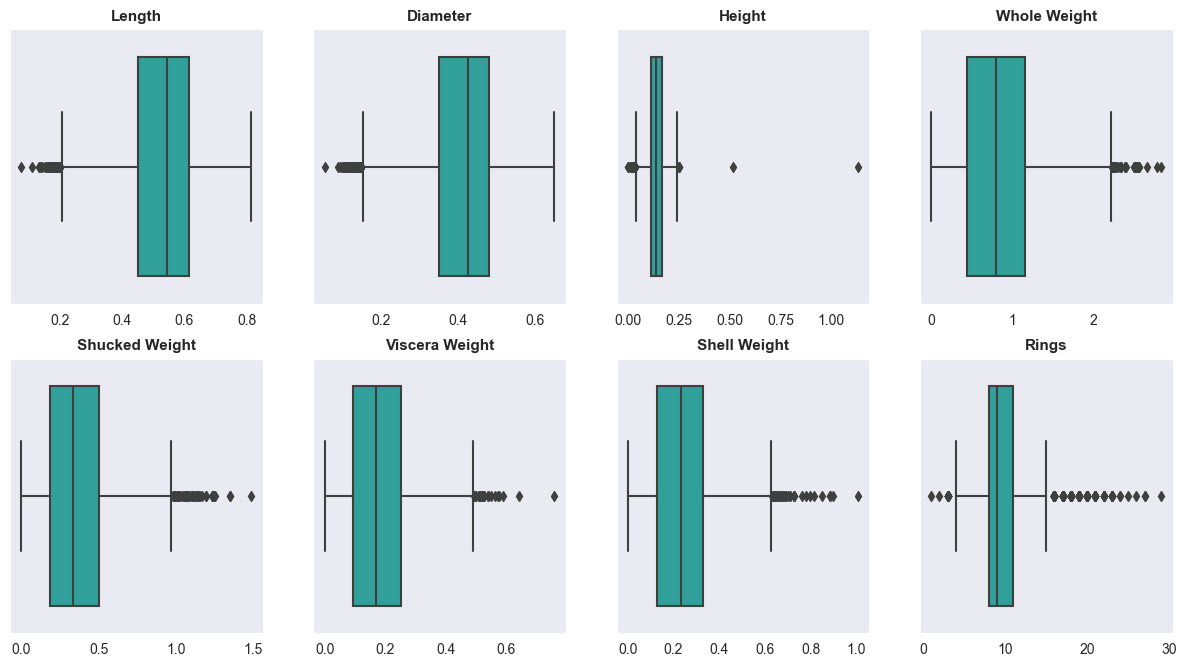

In [38]:
# Check the distribution of each variable (other than sex)
import seaborn as sns
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(2,4)

# Set up the box plots in each subplot
sns.boxplot(x='Length', color='lightseagreen', data=abalone_df, ax=axes[0,0])
sns.boxplot(x='Diameter', color='lightseagreen', data=abalone_df, ax=axes[0,1])
sns.boxplot(x='Height', color='lightseagreen', data=abalone_df, ax=axes[0,2])
sns.boxplot(x='Whole weight', color='lightseagreen', data=abalone_df, ax=axes[0,3])
sns.boxplot(x='Shucked weight', color='lightseagreen', data=abalone_df, ax=axes[1,0])
sns.boxplot(x='Viscera weight', color='lightseagreen', data=abalone_df, ax=axes[1,1])
sns.boxplot(x='Shell weight', color='lightseagreen', data=abalone_df, ax=axes[1,2])
sns.boxplot(x='Rings', color='lightseagreen', data=abalone_df, ax=axes[1,3])

# Format the axes
axes[0,0].set_title('Length', size=11, weight='bold')
axes[0,0].set_xlabel('')

axes[0,1].set_title('Diameter', size=11, weight='bold')
axes[0,1].set_xlabel('')

axes[0,2].set_title('Height', size=11, weight='bold')
axes[0,2].set_xlabel('')

axes[0,3].set_title('Whole Weight', size=11, weight='bold')
axes[0,3].set_xlabel('')

axes[1,0].set_title('Shucked Weight', size=11, weight='bold')
axes[1,0].set_xlabel('')

axes[1,1].set_title('Viscera Weight', size=11, weight='bold')
axes[1,1].set_xlabel('')

axes[1,2].set_title('Shell Weight', size=11, weight='bold')
axes[1,2].set_xlabel('')

axes[1,3].set_title('Rings', size=11, weight='bold')
axes[1,3].set_xlabel('')

sns.set_style('dark')

# Make plots larger
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':100})

# Show plot
plt.show()

The variables in the bottom row all display a right-skewed distributions. Length and diameter are both left-skewed, while height and "whole weight" are both right-skewed. However, logistic regression does not assume linearity, nor does is requrie normality so the skewness is not too concerning. However, the plots show that every variable contains outliers. These outliers can bias our model and hinder model performance. Thus, I will handle the outliers in the code below.

In [102]:
# Itereate through the values in our refined data set
for col, val in abalone_df.iteritems():
    # Use percentile function to find the 25th and 75th percentile 
    # Assign the results
    q25, q75 = np.percentile(abalone_df[col], [25,75])
    # Compute the inner quartile range
    IQR = q75 - q25
    # Find the outliers
    upper = q75 + (IQR*1.5)
    lower = q25 - (IQR*1.5)
    # Check to see which values are lower than 'lower' or greater than 'upper'
    # If a data point is out of bounds, we will replace with null values
    # Otherwise, we will keep it the same
    abalone_df[col+'2'] = np.where((abalone_df[col] > upper) | (abalone_df[col] < lower), np.nan,
                                    abalone_df[col])

Revised box plots with outliers removed

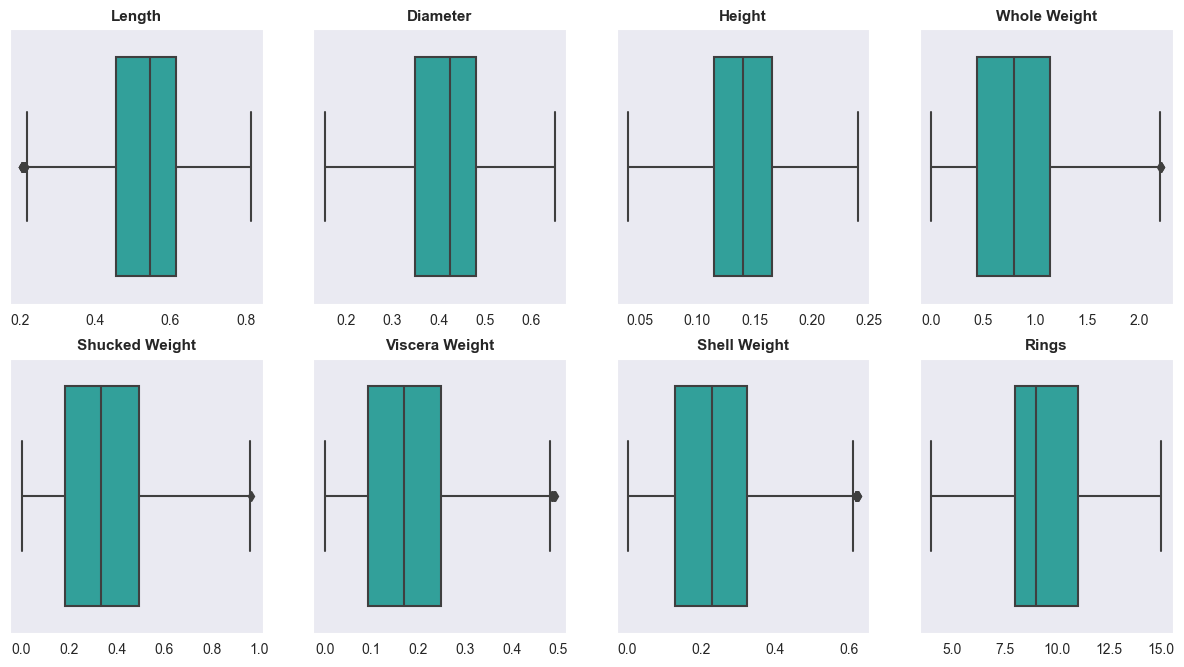

In [86]:
# Check the distribution of each variable (other than sex)
import seaborn as sns
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(2,4)

# Set up the box plots in each subplot
sns.boxplot(x='Length2', color='lightseagreen', data=abalone_df, ax=axes[0,0])
sns.boxplot(x='Diameter2', color='lightseagreen', data=abalone_df, ax=axes[0,1])
sns.boxplot(x='Height2', color='lightseagreen', data=abalone_df, ax=axes[0,2])
sns.boxplot(x='Whole weight2', color='lightseagreen', data=abalone_df, ax=axes[0,3])
sns.boxplot(x='Shucked weight2', color='lightseagreen', data=abalone_df, ax=axes[1,0])
sns.boxplot(x='Viscera weight2', color='lightseagreen', data=abalone_df, ax=axes[1,1])
sns.boxplot(x='Shell weight2', color='lightseagreen', data=abalone_df, ax=axes[1,2])
sns.boxplot(x='Rings2', color='lightseagreen', data=abalone_df, ax=axes[1,3])

# Format the axes
axes[0,0].set_title('Length', size=11, weight='bold')
axes[0,0].set_xlabel('')

axes[0,1].set_title('Diameter', size=11, weight='bold')
axes[0,1].set_xlabel('')

axes[0,2].set_title('Height', size=11, weight='bold')
axes[0,2].set_xlabel('')

axes[0,3].set_title('Whole Weight', size=11, weight='bold')
axes[0,3].set_xlabel('')

axes[1,0].set_title('Shucked Weight', size=11, weight='bold')
axes[1,0].set_xlabel('')

axes[1,1].set_title('Viscera Weight', size=11, weight='bold')
axes[1,1].set_xlabel('')

axes[1,2].set_title('Shell Weight', size=11, weight='bold')
axes[1,2].set_xlabel('')

axes[1,3].set_title('Rings', size=11, weight='bold')
axes[1,3].set_xlabel('')

sns.set_style('dark')

# Make plots larger
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':100})

# Show plot
plt.show()

In [103]:
# Form a complete data set for our analysis. 
# The outliers above were replaced with null values so that we could easily drop them here
# Drop all rows that have any null values, so that we can have a complete data set
abalone_new = abalone_df.dropna(axis = 0, how = 'any')
print(len(abalone_new.index))

3781


In [90]:
# We lost about 9.5% of our data, due to outlier removal
(4177-3781)/4177

0.09480488388795787

In [109]:
import warnings
warnings.filterwarnings('ignore')

# Create age variable
# According to the data information, the age is equal to the number of rings + 1.5
abalone_new['Age'] = abalone_new['Rings'] + 1.5

In [106]:
# Set the final data frame
abalone_final = abalone_new[['Age', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight',
                 'Shell weight', 'M', 'F', 'I']]

# View data frame
abalone_final.head()

,Age,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,M,F,I
0,16.5,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1,0,0
1,8.5,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1,0,0
2,10.5,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,1,0
3,11.5,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,0,0
4,8.5,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,0,1


**3.	Create a decision tree model tuned to the best of your abilities. Explain how you tuned it.**

Prepare the data: Split into trainings vs. testing and standardize the data

In [110]:
# Import necessary modules
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Predictors
X = abalone_final.drop('Age', axis=1)
# Outcome
y = abalone_final['Age']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=33, stratify=y)

#Standardize
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

Create a decision tree model

**4.	Create a random forest model tuned to the best of your abilities. Explain how you tuned it.**

**5.	Create an xgboost model tuned to the best of your abilities. Explain how you tuned it.** 

**6.	Which model performed best? What is your performance metric? Why?** 